In [581]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
import random
from scipy.stats import t
import scipy.stats as st
import numpy as np
import collections
from numbers import Number
from __future__ import division
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 15, 6
use_colours = {0: "blue", 1: "red"}

In [582]:
df = pd.read_csv("fact_slaughter_monthly.csv")

In [583]:
df.head()

,id,yearmonth,geo,unit_head,unit_weight,product,slaughter_head,slaughter_weight,source
0,686655,201408,JAPAN,head,kg/carcass,hog,1222376.0,77.000039,alic_hog_slaughtering
1,686654,201407,JAPAN,head,kg/carcass,hog,1335351.0,77.599972,alic_hog_slaughtering
2,686653,201406,JAPAN,head,kg/carcass,hog,1250429.0,77.800019,alic_hog_slaughtering
3,686652,201405,JAPAN,head,kg/carcass,hog,1315305.0,78.000008,alic_hog_slaughtering
4,686651,201404,JAPAN,head,kg/carcass,hog,1389609.0,78.199983,alic_hog_slaughtering


In [584]:
corr = df.corr()
print(corr)

                        id  yearmonth  slaughter_head  slaughter_weight
id                1.000000   0.520093        0.016478         -0.025285
yearmonth         0.520093   1.000000        0.046569         -0.034226
slaughter_head    0.016478   0.046569        1.000000          0.231253
slaughter_weight -0.025285  -0.034226        0.231253          1.000000


In [585]:
df.yearmonth = df.yearmonth.astype(str)

In [586]:
unique_products = df["product"].unique()
print(unique_products)

['hog' 'pigmeat' 'Heifer' 'Bovine meat' 'Meat of rabbits' 'Other poultry'
 'Guinea fowl' 'Goose' 'Turkey' 'Duck' 'Boiling hen' 'Broiler' 'chicken'
 'Poultry meat' 'Meat of horses- asses- mules or hinnies' 'Goat' 'Mutton'
 'Lamb' 'sheep' 'Meat of sheep and goats' 'Meat of bovine animals']


In [587]:
df.product = df["product"].astype(str)

In [588]:
df_group = df.groupby(["product"]).count()

In [589]:
df_group

,id,yearmonth,geo,unit_head,unit_weight,slaughter_head,slaughter_weight,source
product,,,,,,,,
Boiling hen,7680,7680,7680,7680,7680,970,1295,7680
Bovine meat,960,960,960,960,960,917,917,960
Broiler,7680,7680,7680,7680,7680,1489,1821,7680
Duck,7680,7680,7680,7680,7680,2727,3011,7680
Goat,7680,7680,7680,7680,7680,4813,4966,7680
Goose,7680,7680,7680,7680,7680,963,1194,7680
Guinea fowl,7680,7680,7680,7680,7680,732,907,7680
Heifer,3360,3360,3360,3360,3360,2708,2708,3360
Lamb,7680,7680,7680,7680,7680,5046,5144,7680


Picking the categories with most and least observations to check the preditctive power of our algorithm

Trying to run the code for two of these categories 

In [590]:
df_hog= df[df.product == "hog"]
df_mutton = df[df.product == "Mutton"]

In [591]:
df_hog = df_hog.reset_index()
df_mutton = df_mutton.reset_index()

In [592]:
ts = df_hog["slaughter_weight"]
ts_mutton = df_mutton["slaughter_weight"]

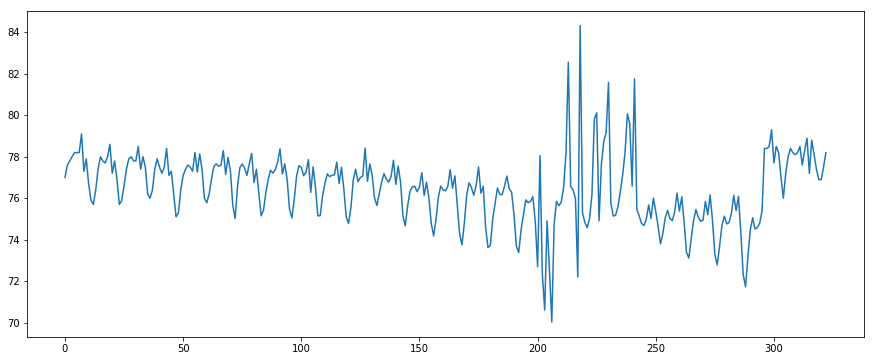

In [593]:
plt.plot(ts)


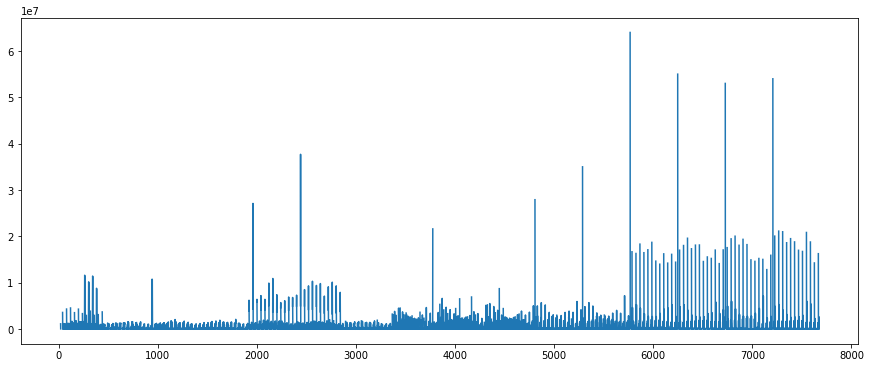

In [594]:
plt.plot(ts_mutton)

In [595]:
index = df_hog.index.values

In [596]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

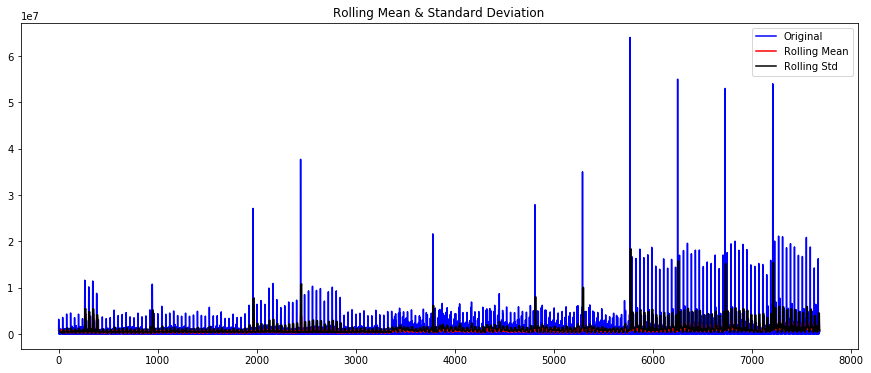

Results of Dickey-Fuller Test:
Test Statistic                -1.422659e+01
p-value                        1.623371e-26
#Lags Used                     3.500000e+01
Number of Observations Used    7.644000e+03
Critical Value (5%)           -2.861918e+00
Critical Value (1%)           -3.431206e+00
Critical Value (10%)          -2.566971e+00
dtype: float64


In [597]:
df_mutton.slaughter_weight = df_mutton.slaughter_weight.fillna(np.mean(df_mutton.slaughter_weight))
ts_mutton = df_mutton["slaughter_weight"]
test_stationarity(ts_mutton)

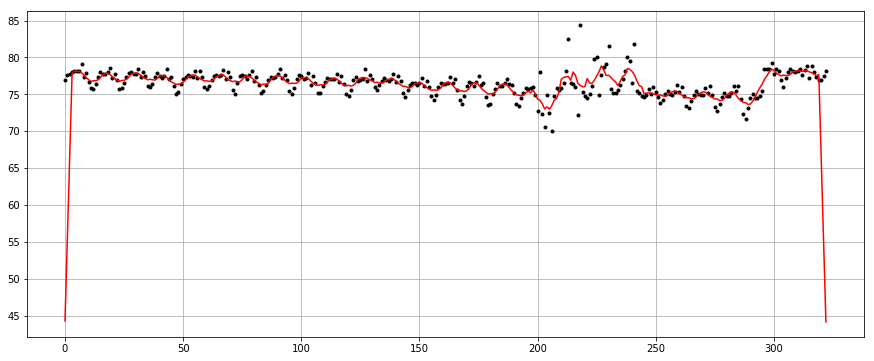

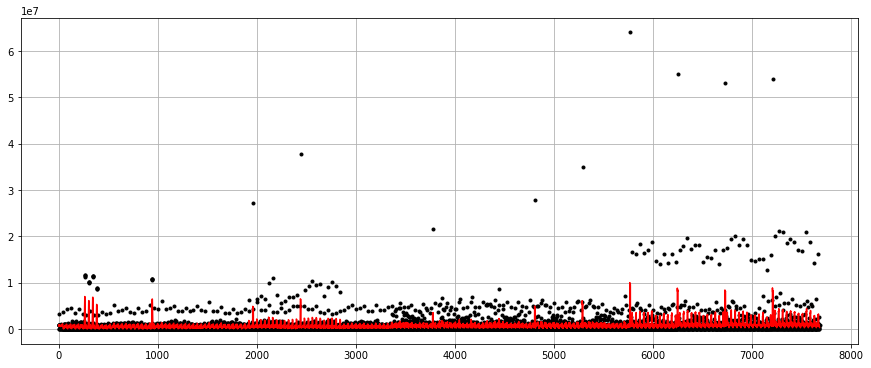

In [598]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = index
y = df_hog.slaughter_weight


plt.plot(x,y,"k.")
y_av = movingaverage(y, 7)
plt.plot(x, y_av,"r")
plt.grid(True)
plt.show()

std = np.std(y_av)
events= []
ind = []
for i in range(len(df_hog.slaughter_weight)):
    if df_hog["slaughter_weight"][i] > y_av[i]+std:
        events.append(df_hog["slaughter_weight"][i])

x = index_mutton
y = df_mutton.slaughter_weight


plt.plot(x,y,"k.")
y_av = movingaverage(y, 7)
plt.plot(x, y_av,"r")
plt.grid(True)
plt.show()

std = np.std(y_av)
events= []
ind = []
for i in range(len(df_mutton.slaughter_weight)):
    if df_mutton["slaughter_weight"][i] > y_av[i]+std:
        events.append(df_mutton["slaughter_weight"][i])

In [599]:
print(len(events),len(df_mutton))

(640, 7680)


In [600]:
df_hog = df_hog.reset_index(drop=True)
df_mutton = df_mutton.reset_index(drop=True)

Since the p value is less than than the 5 % and 10 % critical value and very close to the 1 % level, the null hypothesis can be 
rejected and it can be concluded that the signal is stationary

In [601]:
np.random.seed(0)

In [602]:
df_hog.head()

,index,id,yearmonth,geo,unit_head,unit_weight,product,slaughter_head,slaughter_weight,source
0,0,686655,201408,JAPAN,head,kg/carcass,hog,1222376.0,77.000039,alic_hog_slaughtering
1,1,686654,201407,JAPAN,head,kg/carcass,hog,1335351.0,77.599972,alic_hog_slaughtering
2,2,686653,201406,JAPAN,head,kg/carcass,hog,1250429.0,77.800019,alic_hog_slaughtering
3,3,686652,201405,JAPAN,head,kg/carcass,hog,1315305.0,78.000008,alic_hog_slaughtering
4,4,686651,201404,JAPAN,head,kg/carcass,hog,1389609.0,78.199983,alic_hog_slaughtering


In [603]:
df_mutton.slaughter_head = df_mutton.slaughter_head.fillna(np.mean(df_mutton.slaughter_head))

In [604]:
df_mutton_corr = df_mutton.corr()
df_mutton_corr

,index,id,slaughter_head,slaughter_weight
index,1.000000,-0.643687,0.067127,0.104899
id,-0.643687,1.000000,-0.026749,-0.035862
slaughter_head,0.067127,-0.026749,1.000000,0.299227
slaughter_weight,0.104899,-0.035862,0.299227,1.000000


As can be seen these features doesn't add any variance to the model, moreover id can also be neglected. only date,geo location and the price are relevant features 

Imputation and building the upper and lower bounds for building the Anomaly threshold

In [605]:
df_hog.slaughter_weight = df_hog.slaughter_weight.fillna(np.mean(df_hog.slaughter_weight))
sd = np.std(df_hog["slaughter_weight"])
mean = np.mean(df_hog["slaughter_weight"])
# Upper Bound
X_upper = mean + sd*4
# Lower Bound
X_lower = mean - sd*3

rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.9, high=X_upper*2, size=(50, 1))
X_outliers_2 = rng.uniform(low=X_lower*0.8, high=X_lower*0.5, size=(50, 1))
Outliers_hog = []
Outliers_hog.extend(X_outliers_1)
Outliers_hog.extend(X_outliers_2)

Generating the outliers for evaluation

In [606]:
df_mutton.slaughter_weight = df_mutton.slaughter_weight.fillna(np.mean(df_mutton.slaughter_weight))
sd = np.std(df_mutton["slaughter_weight"])
mean = np.mean(df_mutton["slaughter_weight"])
# Upper Bound
X_upper = mean + sd*4
# Lower Bound
X_lower = mean - sd*0.3
rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.9, high=X_upper*2, size=(50, 1))
X_outliers_2 = rng.uniform(low=X_lower*0.8, high=X_lower*0.5, size=(50, 1))
Outliers_mutton = []
Outliers_mutton.extend(X_outliers_1)
Outliers_mutton.extend(X_outliers_2)

Creating the outlier Class and inserting the anomalous data in the dataset

In [607]:
df_hog["Actual"] = False
df_hog = df_hog.reset_index(drop=True)

In [608]:
df_mutton["Actual"] = False
df_mutton = df_mutton.reset_index(drop=True)

In [609]:
idx = df_hog.index
for i in Outliers_hog:
    loc = np.random.randint(0, len(df_hog))
    df_hog.loc[loc,"slaughter_weight"] = i
    df_hog.loc[loc,"Actual"] = True

In [610]:
idx = df_mutton.index
for i in Outliers_mutton:
    loc = np.random.randint(0, len(df_mutton))
    df_mutton.loc[loc,"slaughter_weight"] = i
    df_mutton.loc[loc,"Actual"] = True

In [580]:
len(df_hog[df_hog.Actual == True])

86

Extracting the features for Boxplot visualization

In [493]:
from sklearn import preprocessing
df_hog_new = df_hog[["slaughter_head","slaughter_weight"]]

#df_neww= df["price"]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled_hog = min_max_scaler.fit_transform(df_hog_new)
df_scaled_hog = pd.DataFrame(df_scaled_hog)
df_scaled_hog = df_scaled_hog.astype('float32')

In [494]:
df_mutton_new = df_mutton[["slaughter_head","slaughter_weight"]]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled_mutton = min_max_scaler.fit_transform(df_mutton_new)
df_scaled_mutton = pd.DataFrame(df_scaled_mutton)
df_scaled_mutton = df_scaled_mutton.astype('float32')

Resizing the array for training autoencoder neural network 

In [495]:
array = np.array(df_scaled_hog)
row,column = array.shape
array = array.reshape((1,row,column))

In [496]:
array.shape

(1, 323, 2)

In [497]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)

In [498]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

In [499]:
test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))
naivedist = np.zeros(len(df_scaled_hog.values))
for i, x in enumerate(array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [500]:
df_hog["naivedist"] = naivedist

In [501]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [502]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [503]:
encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))


In [504]:
dist_hog = np.zeros(len(df_scaled_hog.values))
for i, x in enumerate(array):
    dist_hog[i] = np.linalg.norm(x-decoded[i]) 

In [505]:
df_hog["dist"] = dist_hog

In [506]:
array = np.array(df_scaled_mutton)
row,column = array.shape
array = array.reshape((1,row,column))

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)


# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))

autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))

dist_mutton = np.zeros(len(df_scaled_mutton.values))
for i, x in enumerate(array):
    dist_mutton[i] = np.linalg.norm(x-decoded[i]) 
df_mutton["dist"] = dist_mutton

In [507]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def doubleMADsfromMedian(y,thresh=4):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# Valid Only for Non Stationary time series
def anomaly_detector2(feature,Z=3):
    results = []
    diff_X = []
    index = []
    X= np.sort(feature.price)
    Y = feature[feature.columns[0]]
    for i in range(len(X)):
        if i ==0:
            value = X[i]
        else:
            value = X[i] - X[i-1]
                
        diff_X.append(value)
    X_mean = np.mean(diff_X)
    X_std = np.std(diff_X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    j = 0
    for i in diff_X:
        if X_upper < i or X_lower > i:
            results.append(True)
            index.append(Y[j])
        else:
            results.append(False)
        j = j + 1
    return results,index

# Model for stationary time series
def anomaly_detector1(feature,Z=3):
    results = []
    X= np.sort(feature)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in feature:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results


In [508]:
results_mad_AE = mad_based_outlier(dist_hog)
results_mad_Normal = mad_based_outlier(df_hog.slaughter_weight)
results_per = percentile_based_outlier(df_hog.slaughter_weight)
results_per_AE = percentile_based_outlier(dist_hog)
results_doublemad_AE = doubleMADsfromMedian(dist_hog)
results_doublemad_Normal = doubleMADsfromMedian(df_hog.slaughter_weight)
results_AD = anomaly_detector1(df_hog.slaughter_weight)
results_AD_AE = anomaly_detector1(dist_hog)

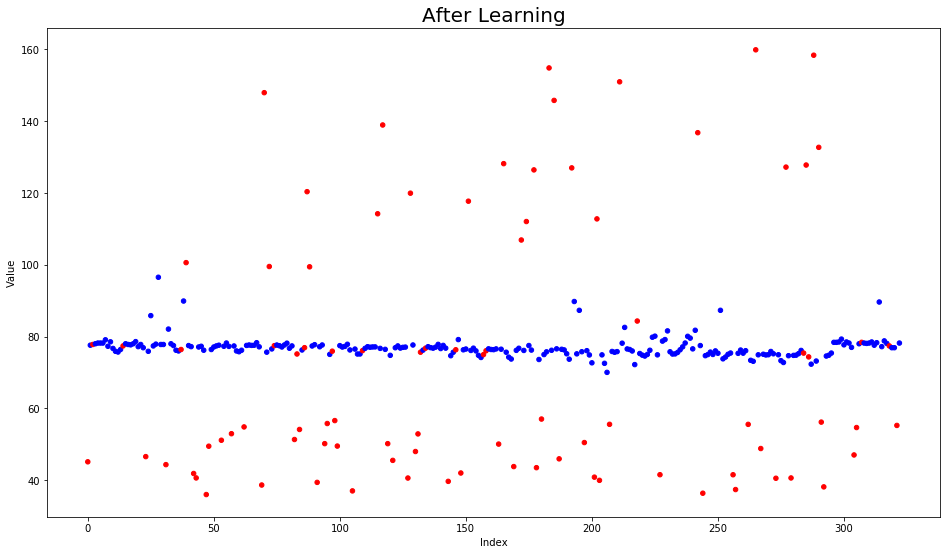

In [509]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_mad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

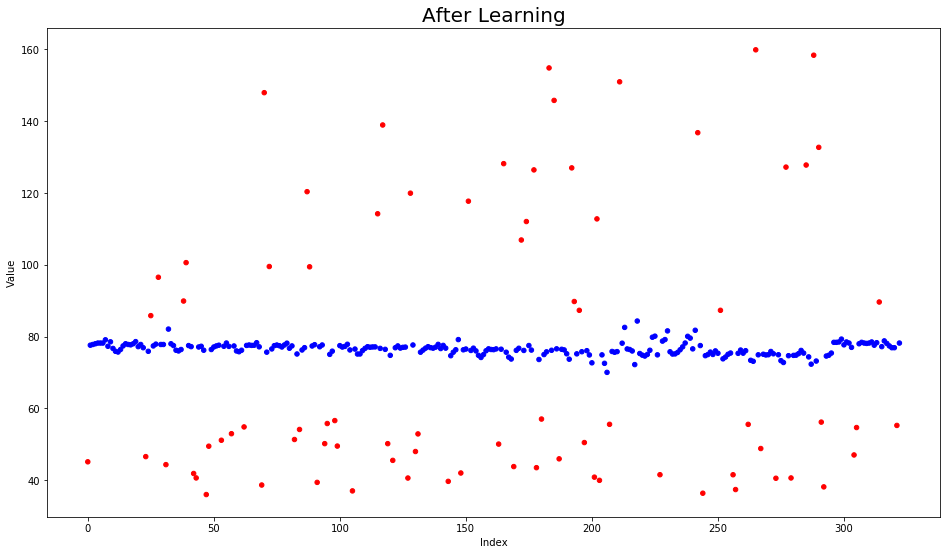

In [510]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_mad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

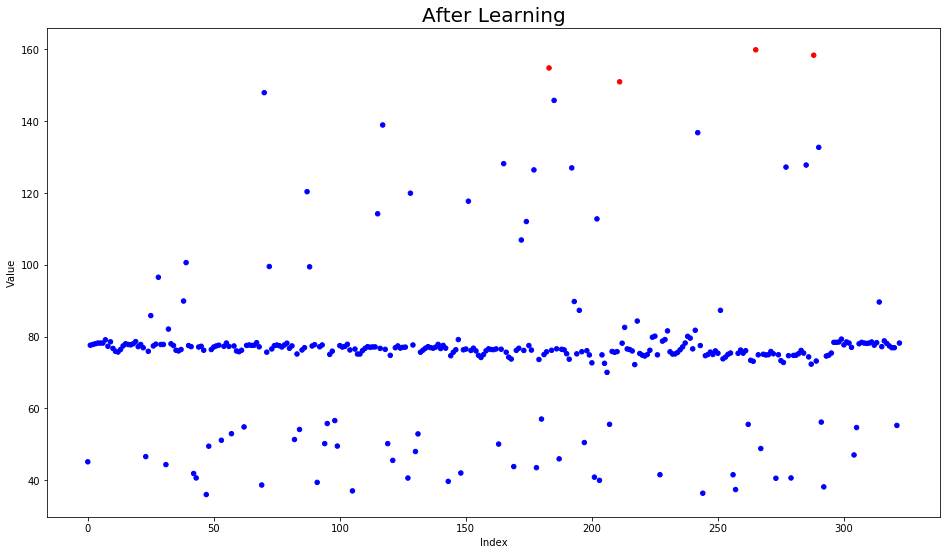

In [511]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_doublemad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

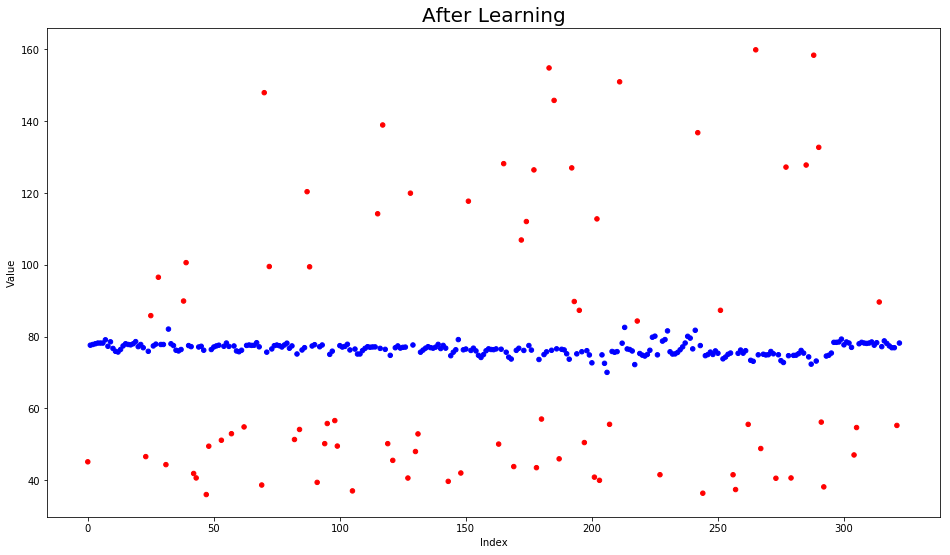

In [512]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'],c=[use_colours[x] for x in results_doublemad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

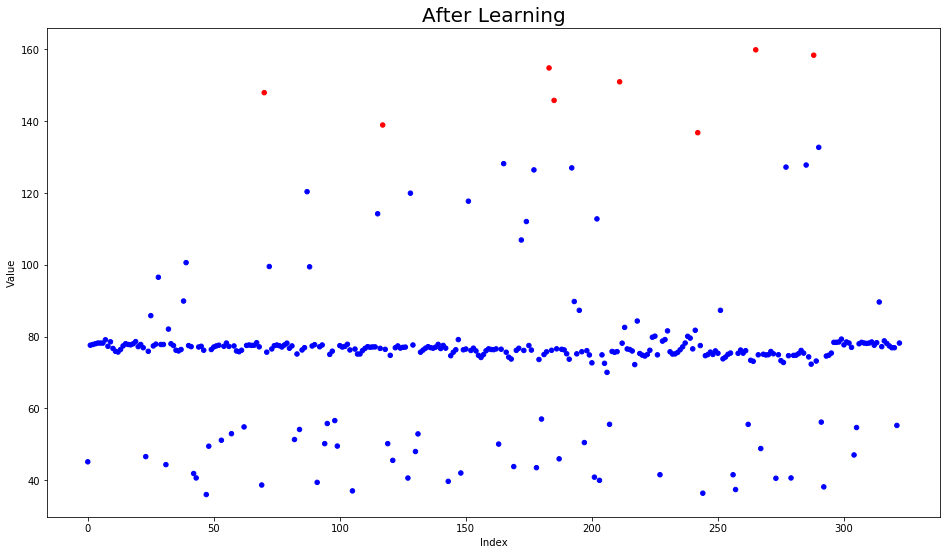

In [514]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_AD], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

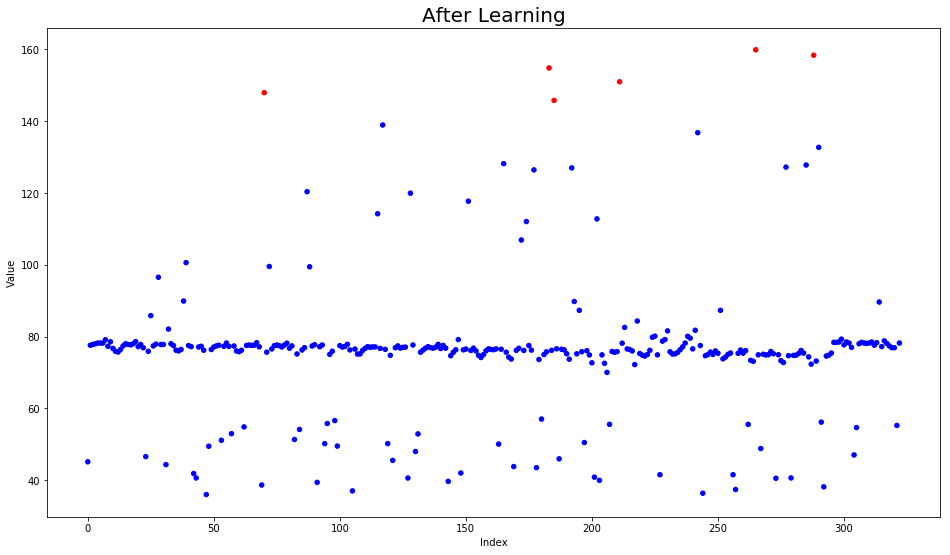

In [515]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_AD_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

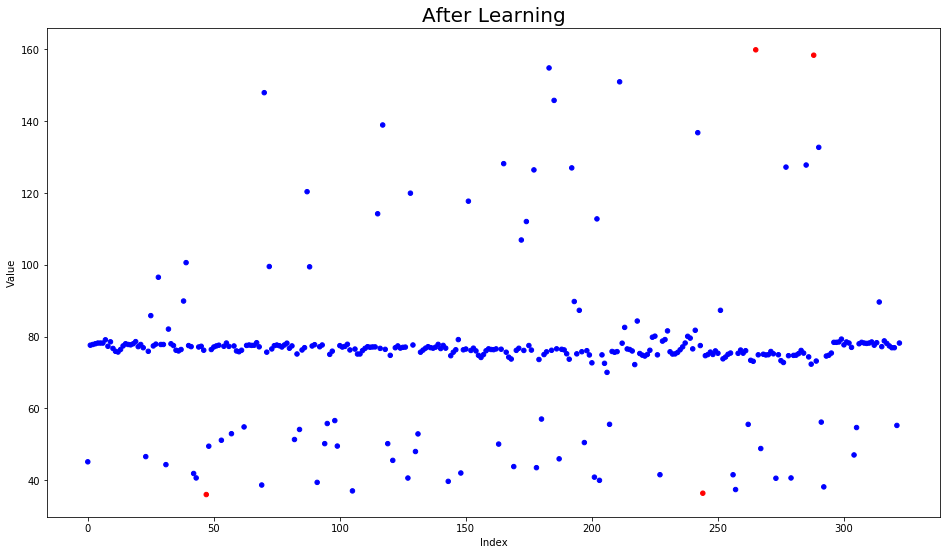

In [516]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_per], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

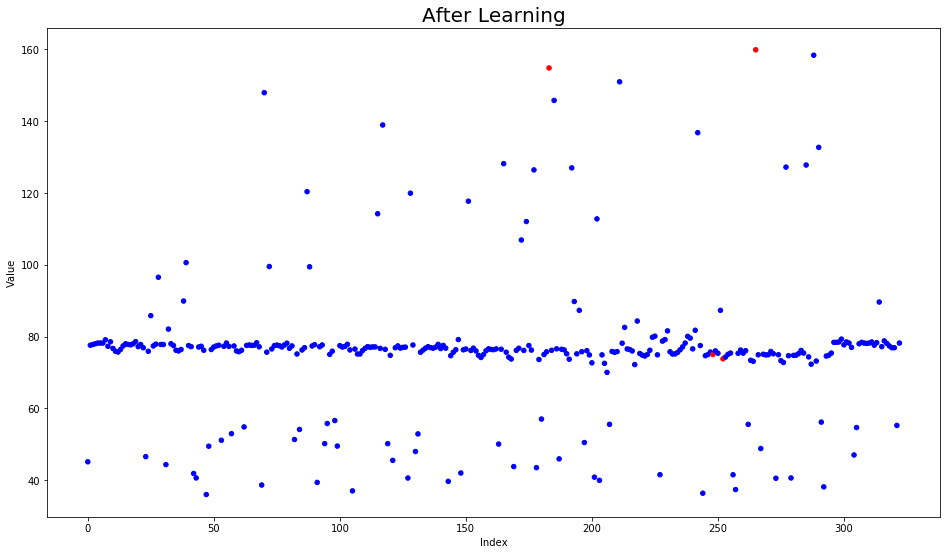

In [517]:

plt.figure(figsize=(16,9))
plt.scatter(df_hog.index, df_hog['slaughter_weight'], c=[use_colours[x] for x in results_per_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [518]:
df_hog["Outlier_MAD_AE"] = results_mad_AE
df_hog["Outlier_MAD_Normal"] = results_mad_Normal 
df_hog["Outlier_PER"] = results_per
df_hog["Outlier_PER_AE"] = results_per_AE
df_hog["Outlier_DoubleMAD_AE"] = results_doublemad_AE
df_hog["Outlier_DoubleMAD_Normal"] = results_doublemad_Normal
df_hog["Outlier_AD"] = results_AD
df_hog["Outlier_AD_AE"] = results_AD_AE

In [519]:
cm=confusion_matrix(df_hog.Actual,df_hog.Outlier_MAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_hog.Actual,df_hog.Outlier_MAD_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.910216718266
Precision of MAD based Outlier detection using Autoencoders is :0.867469879518
Cohen's Kappa: 0.771196169911


In [520]:
cm=confusion_matrix(df_hog.Actual,df_hog.Outlier_DoubleMAD_AE)
print("Accuracy of Double MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Double MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_hog.Actual,df_hog.Outlier_DoubleMAD_AE)))

Accuracy of Double MAD based Outlier detection without Autoencoders is :0.755417956656
Precision of Double MAD based Outlier detection without Autoencoders is:0.0481927710843
Cohen's Kappa: 0.0699784961913


In [521]:
cm=confusion_matrix(df_hog.Actual,df_hog.Outlier_AD_AE)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_hog.Actual,df_hog.Outlier_AD_AE)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.761609907121
Precision of MAD based Outlier detection without Autoencoders is:0.0722891566265
Cohen's Kappa: 0.103780043962


In [522]:
results_mad_AE = mad_based_outlier(dist_mutton)
results_mad_Normal = mad_based_outlier(df_mutton.slaughter_weight)
results_per = percentile_based_outlier(df_mutton.slaughter_weight)
results_per_AE = percentile_based_outlier(dist_mutton)
results_doublemad_AE = doubleMADsfromMedian(dist_mutton)
results_doublemad_Normal = doubleMADsfromMedian(df_mutton.slaughter_weight)
results_AD = anomaly_detector1(df_mutton.slaughter_weight)
results_AD_AE = anomaly_detector1(dist_mutton)

In [523]:
df_mutton["Outlier_MAD_AE"] = results_mad_AE
df_mutton["Outlier_MAD_Normal"] = results_mad_Normal 
df_mutton["Outlier_PER"] = results_per
df_mutton["Outlier_PER_AE"] = results_per_AE
df_mutton["Outlier_DoubleMAD_AE"] = results_doublemad_AE
df_mutton["Outlier_DoubleMAD_Normal"] = results_doublemad_Normal
df_mutton["Outlier_AD"] = results_AD
df_mutton["Outlier_AD_AE"] = results_AD_AE

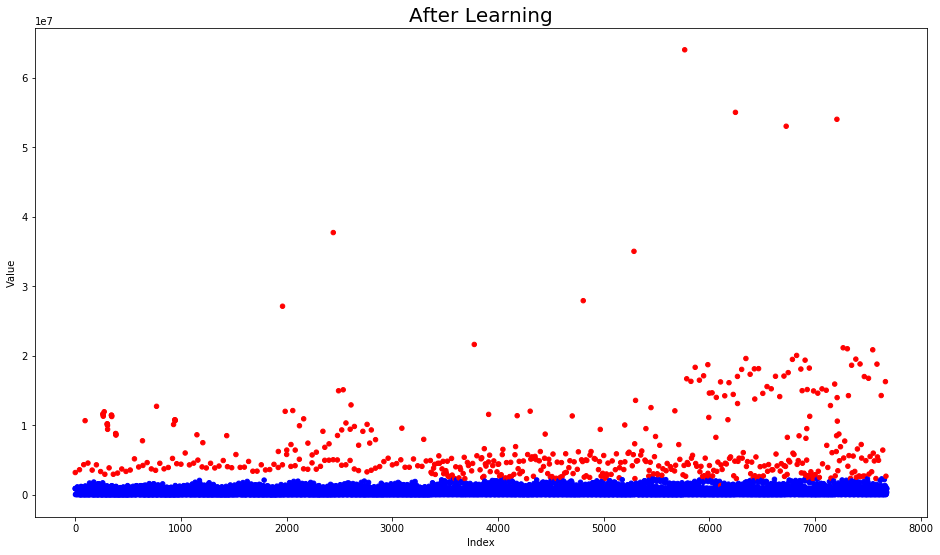

In [525]:
plt.figure(figsize=(16,9))
plt.scatter(df_mutton.index, df_mutton['slaughter_weight'], c=[use_colours[x] for x in results_mad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [526]:
cm=confusion_matrix(df_mutton.Actual,df_mutton.Outlier_MAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df_mutton.Actual,df_mutton.Outlier_MAD_AE)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.93359375
Precision of MAD based Outlier detection using Autoencoders is :0.5
Cohen's Kappa: 0.145326001571


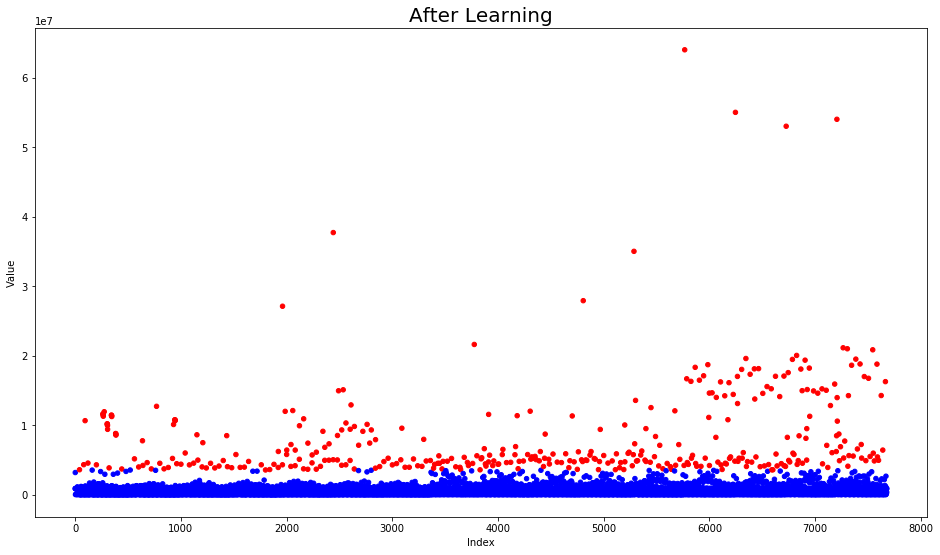

In [527]:
plt.figure(figsize=(16,9))
plt.scatter(df_mutton.index, df_mutton['slaughter_weight'], c=[use_colours[x] for x in results_mad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

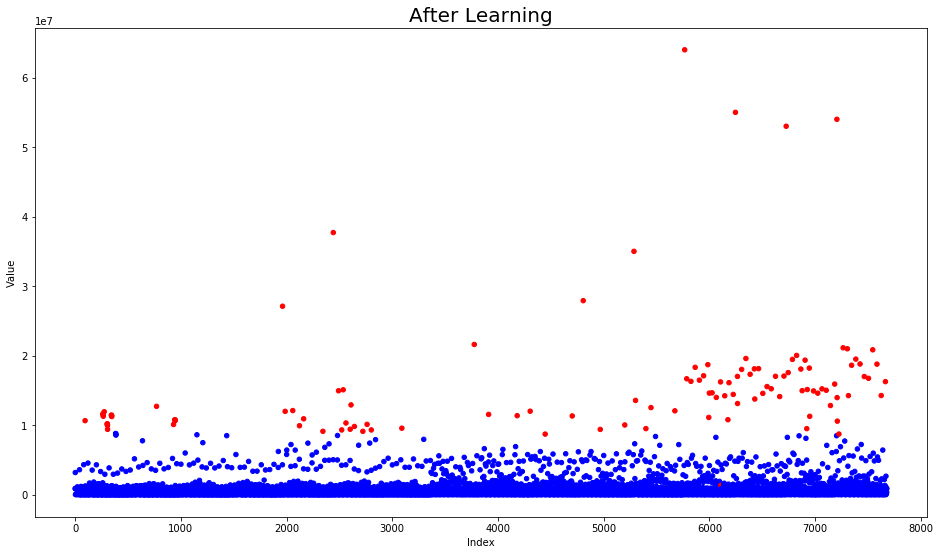

In [528]:
plt.figure(figsize=(16,9))
plt.scatter(df_mutton.index, df_mutton['slaughter_weight'], c=[use_colours[x] for x in results_AD_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

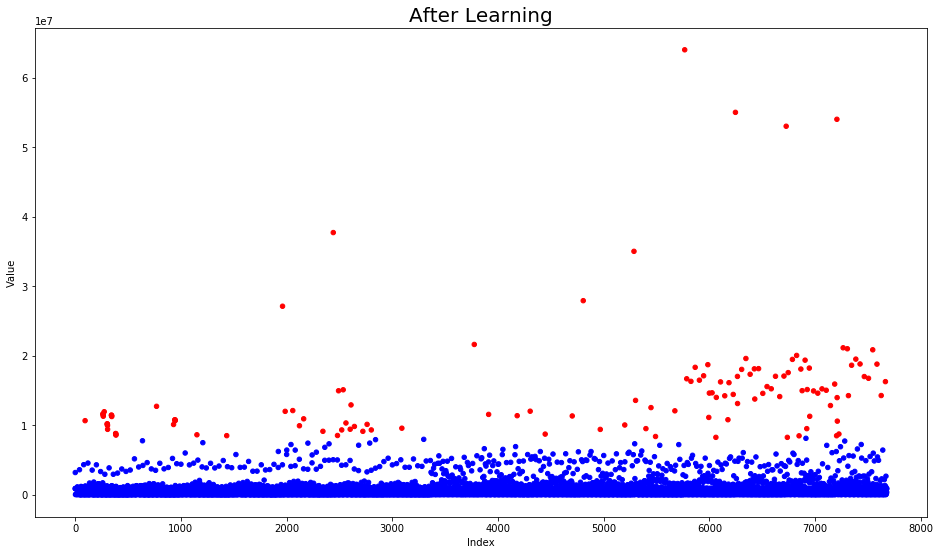

In [529]:
plt.figure(figsize=(16,9))
plt.scatter(df_mutton.index, df_mutton['slaughter_weight'], c=[use_colours[x] for x in results_AD], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

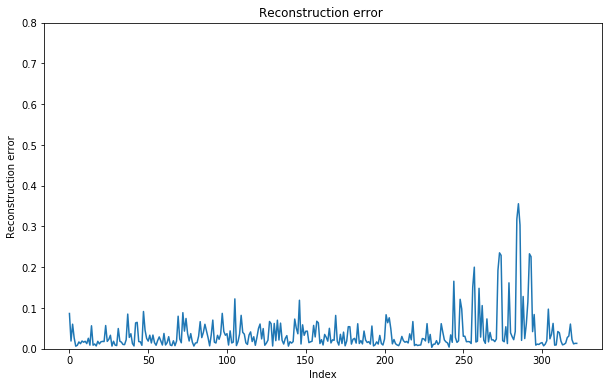

In [284]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

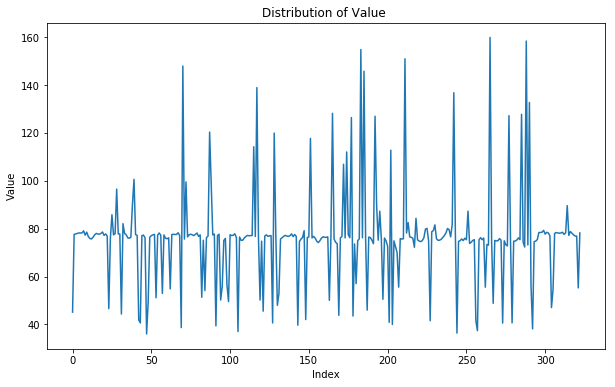

In [285]:
value = np.array(df_hog["slaughter_weight"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")

In [552]:
df_hog_new.head()

,slaughter_head,slaughter_weight
0,1222376.0,45.118510
1,1335351.0,77.599972
2,1250429.0,77.800019
3,1315305.0,78.000008
4,1389609.0,78.199983


In [553]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(df_hog_new,test_size=0.5)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers_hog:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"slaughter_weight"] = i
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test[['slaughter_head','slaughter_weight']]
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [554]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True


In [555]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)

In [556]:
cm

array([[88,  0],
       [73,  1]])

In [551]:
coh = cohen_kappa_score(X_test.Actual,y_pred_test)
print(coh)

0.0475390559382


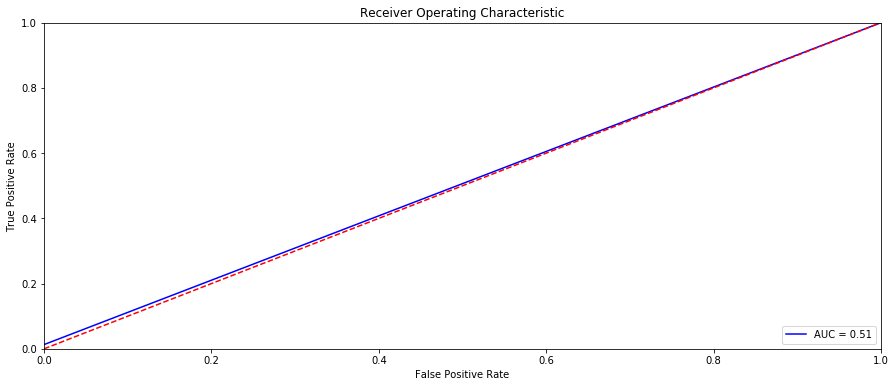

In [535]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [536]:
print("Accuracy of Isolation Forest :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Isolation Forest:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))

Accuracy of Isolation Forest :0.530864197531
Precision of Isolation Forest:0.012987012987


In [537]:
X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub = X_test_sub.reset_index()
X_test_sub.columns.values[0] = "new_index"
X_test_sub["Actual"] = X_test["Actual"]

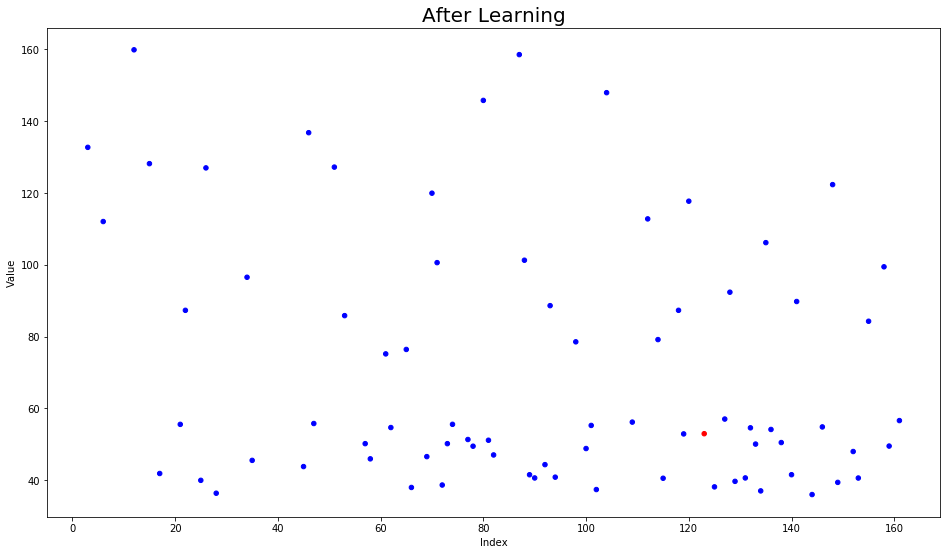

In [538]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["price"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [614]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(df_mutton_new,test_size=0.5)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers_mutton:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"slaughter_weight"] = i
    #print(X_test.loc[loc,"price"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test[['slaughter_head','slaughter_weight']]
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [615]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True

from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)
print(cm)

[[3695   48]
 [  81   16]]


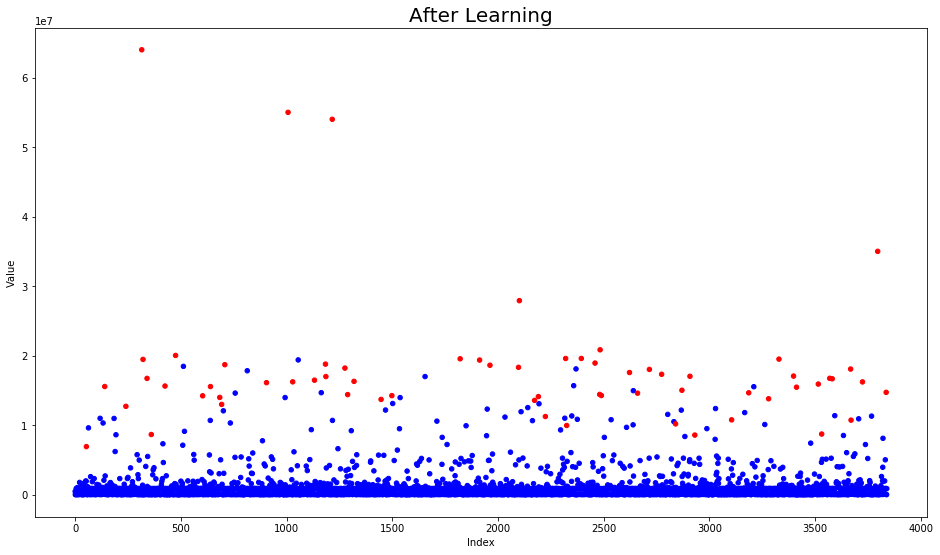

In [616]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["slaughter_weight"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

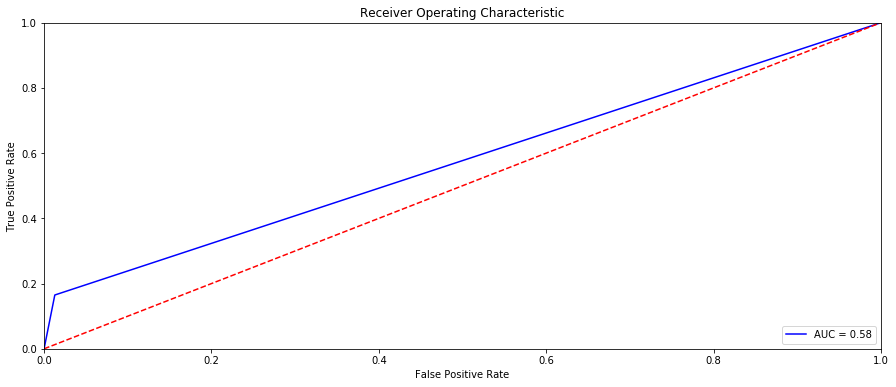

In [617]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()